In [359]:
jupyter = [111,112,113,211,212,214,411,412,413,414,512,613,614,711,713,811,813]
soldering = [425,521,621,722,822]


# IMPORTS & SCHEMA

In [361]:
import json, datetime, time, os
from glob import glob
import pylab as pl
import numpy as np
from scipy import stats
DATA_ROOT = "irb"
STUDY_FEATURES={
    "motion": ["acc-x", "acc-y", "acc-z"], 
    "phasic": ["phasic"],
    "hr": ["hr"], 
    "bio": ["bvp", "temp"],
    "kinnunen": ["getting-started", "dealing-with-difficulties", 
                 "encountering-difficulties", "failing", "submitting", "succeeding"],
    "jupyter": ["execute", "mouseevent", "notebooksaved", "select", "textchunk"], 
    "q": ["q1", "q2", "q3", "q4"], 
    "notes": ["notesmetadata"], 
    "emotion": ["phasic", "hr"]
}

def get_file(folder, prefix):
    user = os.path.basename(folder)
    files = glob(folder + "/"+prefix+"*.json")
    if len(files) == 0:
#         print("File not found", prefix, 'in', folder)
        return None, None
    else: 
        with open(files[0], 'r') as f: 
            contents = json.load(f)
            return contents, files[0]
        
def adjust_data(folder, data, t, Fs):
    metadata,f = get_file(folder, "sessionmetadata")
    if metadata == None:
        print('ERROR')
  
    # ADJUST Y AND T RANGE    
    start = metadata["session_start"] - t
    end = metadata["session_end"] - t    
    t0 = start * Fs 
    t0 = start * Fs  if start > 0 else 0
    tf = end * Fs - 1 if end < len(data) else len(data)
    t0 = int(t0)
    tf = int(tf)
    data = data[t0:tf]
    return data

def save_jsonfile(name, data):
    with open(name, 'w') as outfile:
        json.dump(data, outfile)
    print("File saved!", name)


def normalize(arr, min_v, max_v):
    return list((np.array(arr) - min_v) / (max_v - min_v))

'''
mts is in the dictionary structured as
user: features x t

subsequence routine extracts all L windows with a L/2 overlap
'''
def subsequences(a, L):
    n, m = a.shape
    windows = int(m/L)    
    window_range = np.linspace(0, windows-1, (windows-1) * 2 + 1)
    ss = []
    for x in window_range:
        ss.append(a[:, int(x*L):int((x+1)*L)])
    return np.array(ss)

def subsequenceMTS(umts, L):
    sss = np.array([])
    bounds = [0]
    for u in umts: 
        mts = umts[u]
        ss = subsequences(mts, L)
        print("sequences", u, ss.shape)
        bounds.append(bounds[-1] + ss.shape[0])
        if sss.shape[0] == 0:
            sss = ss
        else:
            sss = np.concatenate((sss, ss))
    word_shape = sss.shape[-2:]
    sss = sss.reshape(sss.shape[0], -1)
    return sss, bounds, word_shape

def compile_features(features):
    feat = []
    for f in features:
        feat.extend(STUDY_FEATURES[f])
    return feat

def time2L(users, mts, seconds):
    u = users[0]
    samples = mts[u].shape[1]
    contents, f = get_file(os.path.join("irb", str(u)), "sessionmetadata")
    total_time = contents["elapsed_time"]
    L = int(seconds/total_time * samples)
    return L
                           
    
    

# COMPUTE FEATURE BOUNDS

In [363]:
all_features = compile_features(["motion", "bio", "jupyter","phasic", "hr","q", "kinnunen"])
mts, tsum, users, maxmin = constructMTS(jupyter, all_features)

datapoints 111 (22, 75317) 22 75317
datapoints 112 (22, 93945) 22 93945
datapoints 113 (22, 72209) 22 72209
datapoints 211 (22, 75811) 22 75811
datapoints 212 (12, 71876) 12 71876
datapoints 214 (22, 100379) 22 100379
datapoints 411 (22, 84250) 22 84250
datapoints 412 (22, 79509) 22 79509
datapoints 413 (12, 89964) 12 89964
datapoints 414 (22, 82342) 22 82342
datapoints 512 (22, 94846) 22 94846
datapoints 613 (22, 103280) 22 103280
datapoints 614 (22, 103071) 22 103071
datapoints 711 (12, 95402) 12 95402
datapoints 713 (12, 64593) 12 64593
datapoints 811 (22, 80545) 22 80545
datapoints 813 (22, 87327) 22 87327


In [162]:
fbounds = {}
for i in maxmin: 
    f = all_features[i]
    f_min = min(maxmin[i][0])
    f_max = max(maxmin[i][1])
    fbounds[f] = (f_min, f_max)
#     print(f, f_min, f_max)
print(fbounds)

{'acc-x': (-128.0, 127.0), 'acc-y': (-128.0, 127.0), 'acc-z': (-128.0, 127.0), 'bvp': (-2356.85, 2467.51), 'temp': (27.75, 34.39), 'execute': (0, 29), 'mouseevent': (0, 1), 'notebooksaved': (-162, 370), 'select': (0.0, 0.9545454545454546), 'textchunk': (0, 276), 'phasic': (-0.37003947947894344, 167.52530136948076), 'hr': (55.9, 142.1), 'q1': (0.0, 1.0), 'q2': (0.0, 1.0), 'q3': (0.0, 1.0), 'q4': (0.0, 1.0), 'getting-started': (0.0, 1.0), 'dealing-with-difficulties': (0.0, 1.0), 'encountering-difficulties': (0.0, 1.0), 'failing': (0.0, 1.0), 'submitting': (0.0, 1.0), 'succeeding': (0.0, 1.0)}


In [364]:
# (start, end)
def sparsify(arr, intervals=True):
    segments = []
    curr_segment = None
    for i, v in enumerate(arr):
        if v >= 0.5: 
            if not curr_segment:
                curr_segment = [i, None]
        else:
            if curr_segment:
                curr_segment[1] = i
                if not intervals:
                    segments.append(curr_segment[1]-curr_segment[0])
                else:
                    segments.append(curr_segment)
                curr_segment = None
    if curr_segment:
        curr_segment[1] = len(arr)
        if not intervals:
            segments.append(curr_segment[1]-curr_segment[0])
        else:
            segments.append(curr_segment)

            return segments
    return segments

In [365]:
def compute_kinnunen(users, mts):
    ontology = {}
    k = STUDY_FEATURES["kinnunen"]
    k_n = len(k)


    for i, u in enumerate(users):
        data = mts[u]
        k_f = data[0:k_n]
        f = data[k_n:]


        for j, code in enumerate(k):
            if not code in ontology: 
                ontology[code] = {
                    "interval": [],
                    "data": [], 
                    "raw": []
                }
            ontology[code]["interval"].append(sparsify(k_f[j]))
            mask = k_f[j] >= 0.5
            ontology[code]["data"].append(f[:, mask])
            ontology[code]["raw"].append(f)

    # ASSERT CORRECT STRUCTURE
    if False:
        print("SANITY CHECK")
        for code in ontology:
            x = ontology[code]

            for i in range(0, len(x["data"])):
                s = sum(x["interval"][i])
                n = len(x["interval"][i])
                d = x["data"][i].shape

                print(i, "\t", code, s, d, "segs=", n)

    for code in ontology:
        x = ontology[code]
        ontology[code]["segments"] = []

        for i in range(0, len(x["data"])):
            intervals = x["interval"][i]
            data = x["data"][i]#.reshape(-1)
            idx = 0
            for start, end in intervals:
                L = end - start
                segment = data[:, idx:idx+L]
                idx = idx + L
                ontology[code]["segments"].append(segment)

    return ontology

In [366]:
def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

def describe_ontology(ontology, title):
    print("#", title)
    means_arr = []
    for i, code in enumerate(ontology):
        segments = ontology[code]["segments"]
        n = len(segments)
        means = [np.mean(seg) for seg in segments]
        means = reject_outliers(np.array(means))
        pop_mean = np.mean(means)
        pop_variance = np.std(means)        
        means_arr.append(means)
        print("%40s %3.2f [%0.2f] n=%10f"%(code, pop_mean * 100, pop_variance * 100, n))
    
    return means_arr

In [367]:
def extractMTS(users, features):
    tsum = 0
    umts = {}
    for user in users: 
        mts = []
        folder = os.path.join(DATA_ROOT, str(user))
            
        for feature in features: 
            contents, f = get_file(folder, feature)
            if not f:
                continue
                
            #Frequnecy encoded feature
            if "sampling_rate" in contents:
                data = contents["data"]           
                t = contents["timestamp"]
                F = contents["sampling_rate"]
                data = adjust_data(folder, data, t, F)
                mts.append(data)
                tsum = tsum + len(data)
            #Time encoded feature
            else:
                data = contents["data"]["y"]  
                mts.append(data)
                tsum = tsum + len(data)
        if len(mts) > 0:
            umts[user] = mts
        else:
            print("Insufficient data for %s. Not included in final MTS."%user)
    return umts, tsum


# Construct final representation    
def resampleFeatureMTS(umts, features, rejectIncomplete = False):   
    if rejectIncomplete:
        print("Rejecting incomplete features")
        umts_validated = {}
        for u in umts: 
            mts = umts[u]
            if(len(mts) != len(features)):
                print("Insufficient feature data for %s. Not included in final MTS."%u)
                continue
            else:
                umts_validated[u] = mts
        umts = umts_validated  
        
    for u in umts:
        mts = umts[u]
        
        max_t = len(max(mts, key=lambda f: len(f)))
        fmts = np.zeros((len(mts), max_t))
    
        print('datapoints', u, fmts.shape, len(mts), max_t)
        # Not enough feature data
        
        for i, f in enumerate(mts):
            if(len(f) < max_t):
                oldf = len(f)
                told = np.linspace(0, 1, len(f))
                tnew = np.linspace(0, 1, max_t)
                f = np.interp(tnew, told, f)                
            fmts[i, :] = f
        umts[u] = fmts
    return umts


'''
MAKES A MTS FOR A GROUP OF USERS AND A SET OF FEATURES
FBOUNDS TAKES A MAXMIN MAP OF FEATURE VALUES TO NORMALIZE THE SET
'''
def constructMTS(users, features, fbounds = None):     
    umts, tsum = extractMTS(users, features)
    maxmin = maxMinFeatures(umts)
    
    if fbounds:
        print("Adjusting feature bounds")
        for u in umts:
            mts = umts[u]
            for i, f in enumerate(mts):
                min_v, max_v = fbounds[features[i]]
                mts[i] = normalize(f, min_v, max_v)
                
    umts = resampleFeatureMTS(umts, features, fbounds)
    return umts, tsum, list(umts.keys()), maxmin

# MATRIX CREATION 

## Dataset: Good Sessions versus Bad Sessions

In [368]:
window_size = 5#s
features = compile_features(["emotion"])

In [369]:
good_session = [211,613,112,214,411,614,711,212,512,713]
users = good_session

mts, tsum, users, maxmin = constructMTS(users, features, fbounds)
L = time2L(users, mts, window_size)
sss, bounds, word_shape = subsequenceMTS(mts, L)
print(L, sss.shape)

dataset_name = "good_session.json"
description = "Rated above a 4 on Overall Coding Session Rating"

Insufficient data for 711. Not included in final MTS.
Insufficient data for 212. Not included in final MTS.
Insufficient data for 512. Not included in final MTS.
Insufficient data for 713. Not included in final MTS.
Adjusting feature bounds
Rejecting incomplete features
14 14
14 14
14 14
14 14
14 14
14 14
datapoints 211 (14, 75811)
datapoints 613 (14, 103280)
datapoints 112 (14, 93945)
datapoints 214 (14, 100379)
datapoints 411 (14, 84250)
datapoints 614 (14, 103071)
sequences 211 (473, 14, 319)
sequences 613 (645, 14, 319)
sequences 112 (587, 14, 319)
sequences 214 (627, 14, 319)
sequences 411 (527, 14, 319)
sequences 614 (645, 14, 319)
319 (3504, 4466)


In [369]:
def maxMinFeatures(umts):
    #MIN_MAX per features
    maxmin = {}
    for u in umts:
        mts = umts[u]
        for i, f in enumerate(mts):
            if not i in maxmin:
                maxmin[i] = []
            maxmin[i].append((min(f), max(f)))
    for x in maxmin: 
        maxmin[x] = [ii for ii in zip(*maxmin[x])]
    return maxmin


## Codebook Datasets

In [370]:
feat = "emotion"
window_size = 5#s
features = compile_features([feat])

users = jupyter

mts, tsum, users, maxmin = constructMTS(users, features, fbounds)
L = time2L(users, mts, window_size)
sss, bounds, word_shape = subsequenceMTS(mts, L)
print("%s s window_size, %s samples/window, %s windows, %i # of features/window, n=%i"%(window_size, L, sss.shape[0], sss.shape[1], len(users)))
print("word_shape")
dataset_name = feat+"_codebook.json"
description = feat+" breakdown for all users."
meta = {
    "L": L,
    "window_size": window_size,
    "bounds": bounds,
    "word_shape": word_shape,
    "description": description,
    "users": users, 
    "features": features, 
    "subsequences": sss.tolist()
}
save_jsonfile(os.path.join("irb/datasets", dataset_name), meta)

Adjusting feature bounds
Rejecting incomplete features
datapoints 111 (2, 4706) 2 4706
datapoints 112 (2, 5870) 2 5870
datapoints 113 (2, 4512) 2 4512
datapoints 211 (2, 4737) 2 4737
datapoints 212 (2, 4491) 2 4491
datapoints 214 (2, 6272) 2 6272
datapoints 411 (2, 5264) 2 5264
datapoints 412 (2, 4968) 2 4968
datapoints 413 (2, 5621) 2 5621
datapoints 414 (2, 5145) 2 5145
datapoints 512 (2, 5926) 2 5926
datapoints 613 (2, 6454) 2 6454
datapoints 614 (2, 6441) 2 6441
datapoints 711 (2, 5961) 2 5961
datapoints 713 (2, 4036) 2 4036
datapoints 811 (2, 5033) 2 5033
datapoints 813 (2, 5456) 2 5456
sequences 111 (493, 2, 19)
sequences 112 (615, 2, 19)
sequences 113 (473, 2, 19)
sequences 211 (497, 2, 19)
sequences 212 (471, 2, 19)
sequences 214 (659, 2, 19)
sequences 411 (553, 2, 19)
sequences 412 (521, 2, 19)
sequences 413 (589, 2, 19)
sequences 414 (539, 2, 19)
sequences 512 (621, 2, 19)
sequences 613 (677, 2, 19)
sequences 614 (677, 2, 19)
sequences 711 (625, 2, 19)
sequences 713 (423, 2, 

# Visualize MTS Matrix

111 (4, 1177)
112 (4, 1468)
113 (4, 1129)
211 (4, 1185)
214 (4, 1569)
411 (4, 1317)
412 (4, 1243)
414 (4, 1287)
512 (4, 1482)
613 (4, 1614)
614 (4, 1611)
811 (4, 1259)
813 (4, 1365)


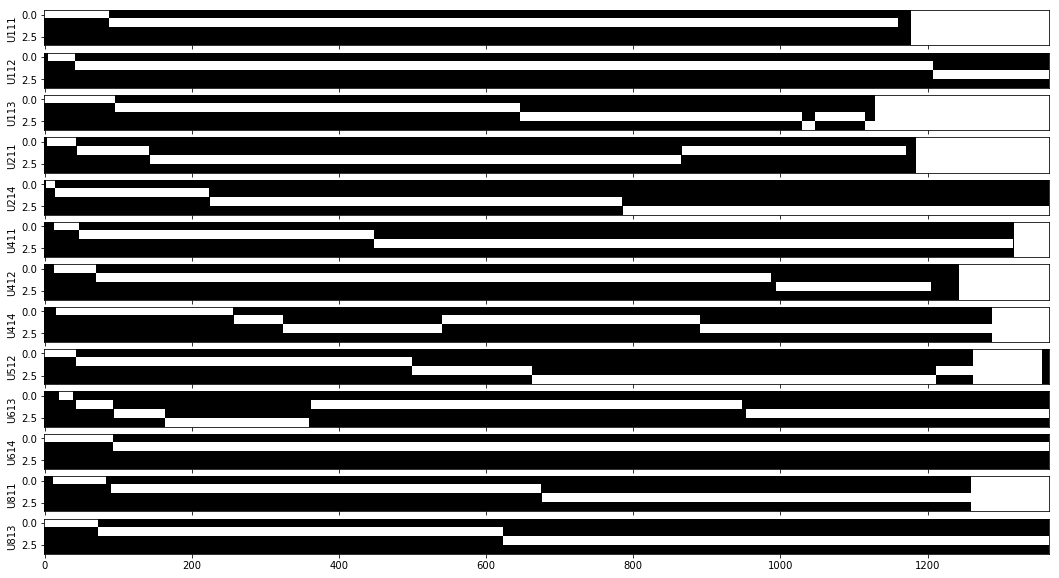

In [350]:
pl.rcParams['figure.figsize'] = [18, 10]

fig, axs = pl.subplots(len(users), 1, sharex=True)
    
user = users[0]
for i, u in enumerate(users):
    print(u, mts[u].shape)
    axs[i].set_ylabel("U%s"% u)
    axs[i].imshow(mts[u], cmap='gray', interpolation='nearest', aspect='auto')
#     pl.title("User %i: %s" % (u, ",".join(features)))
#     pl.ylabel("Acceleration(1/64g)")
#     pl.xlabel("Sample")
pl.show()

# Ontology

In [351]:
def color_plot(bp, edge_color, fill_color):
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
        pl.setp(bp[element], color=edge_color)

    for patch in bp['boxes']:
        patch.set(facecolor=fill_color)       


['getting-started', 'dealing-with-difficulties', 'encountering-difficulties', 'failing', 'submitting', 'succeeding']


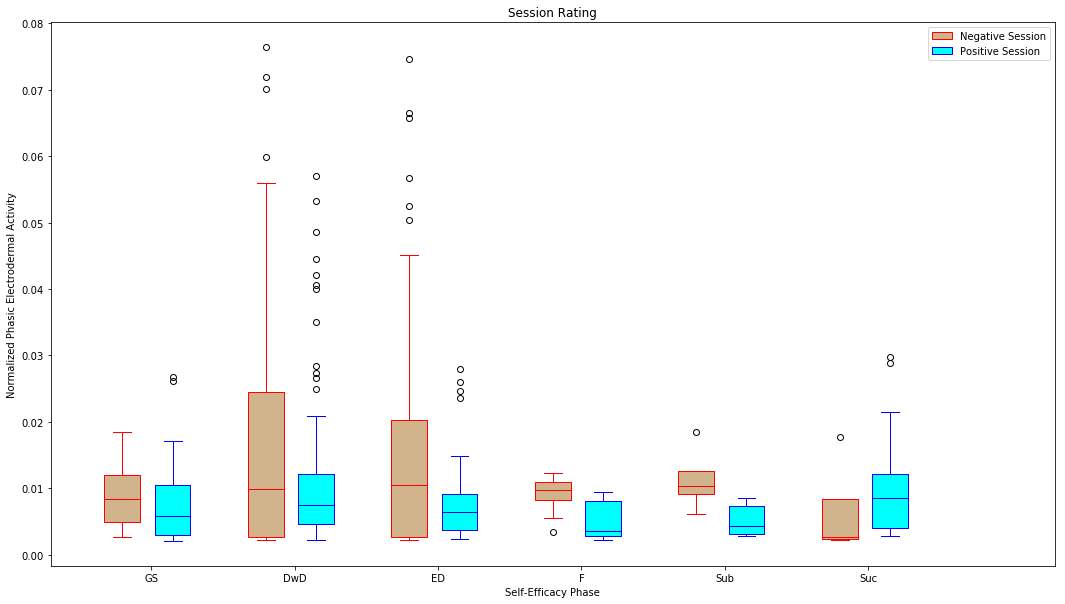

In [352]:
fig1, ax1 = pl.subplots()
ax1.set_title("Session Rating")
pos_a = np.arange(0, 6)
pos_b = np.arange(0, 6) + 0.35
bp1 = ax1.boxplot(data_bad,  positions=pos_a, widths=0.25, patch_artist=True)
color_plot(bp1, 'red', 'tan')
bp2 = ax1.boxplot(data_good,  positions=pos_b, widths=0.25, patch_artist=True)
color_plot(bp2, 'blue', 'cyan')
ax1.set_xlim(-0.5, 6.5)
labels = list(ontology.keys())
print(labels)
pl.ylabel("Normalized Phasic Electrodermal Activity")
pl.xlabel("Self-Efficacy Phase")
pl.xticks(np.arange(0, 6) + 0.20, ('GS', 'DwD', 'ED', 'F', 'Sub', 'Suc'))
pl.legend([bp1["boxes"][0], bp2["boxes"][0]], ('Negative Session', 'Positive Session'), loc='upper right')
pl.show()



In [371]:
bad_session = [412,414,113,813]
users = bad_session

mts, tsum, users, maxmin = constructMTS(users, features, fbounds)
L = time2L(users, mts, window_size)
sss, bounds, word_shape = subsequenceMTS(mts, L)
print(L, sss.shape)

dataset_name = "bad_session.json"
description = "Rated below a 4 on Overall Coding Session Rating"

Adjusting feature bounds
Rejecting incomplete features
14 14
14 14
14 14
14 14
datapoints 412 (14, 79509)
datapoints 414 (14, 82342)
datapoints 113 (14, 72209)
datapoints 813 (14, 87327)
sequences 412 (497, 14, 319)
sequences 414 (515, 14, 319)
sequences 113 (451, 14, 319)
sequences 813 (545, 14, 319)
319 (2008, 4466)


In [274]:
#save_ontology_for_viz
k = STUDY_FEATURES["kinnunen"]
k_n = len(k)
print(features)
exports = {}
for code in ontology:
    x = ontology[code]
    exports[code] = []
    segments = x["segments"]
   
    n_users = len(x["data"])
    for i in range(0, n_users):
        intervals = x["interval"][i]
        raw_d = x["raw"][i]
#         print(raw_d.shape)
        total_t = raw_d.shape[1]
        data = x["data"][i]#.reshape(-1)
        idx = 0
        for s,e in intervals: 
            start = s/total_t
            end = e/total_t
            
            L = e - s
#             print(L/total_t, (end-start))
            segment = data[:, idx:idx+L]
            idx = idx + L
            exports[code] .append({
                "from": start,
                "to": end,
                "data": segment.tolist()
            })
        


metadata= {
    "name": "Good session bio segments",
    "features": features[k_n:],
    "data": exports
}
file = "irb/datasets/stats_motion_good.json"
save_jsonfile(file, metadata)

['getting-started', 'dealing-with-difficulties', 'encountering-difficulties', 'failing', 'submitting', 'succeeding', 'phasic']


FileNotFoundError: [Errno 2] No such file or directory: 'irb/datasets/stats_motion_good.json'

In [306]:
features = compile_features(["kinnunen", "phasic"])
users = [412,414,113,813]
mts, tsum, users, maxmin = constructMTS(users, features, fbounds)
ontology = compute_kinnunen(users, mts)
data_bad = describe_ontology(ontology, "bad")

Adjusting feature bounds
Rejecting incomplete features
datapoints 412 (7, 4968)
datapoints 414 (7, 5145)
datapoints 113 (7, 4512)
datapoints 813 (7, 5456)
# bad
                         getting-started 0.88 [0.49] n= 12.000000
               dealing-with-difficulties 1.91 [2.15] n= 61.000000
               encountering-difficulties 1.75 [1.96] n= 53.000000
                                 failing 0.91 [0.29] n=  8.000000
                              submitting 1.14 [0.45] n=  4.000000
                              succeeding 0.63 [0.53] n=  8.000000


In [306]:
features = compile_features(["kinnunen", "phasic"])
users = [412,414,113,813]
mts, tsum, users, maxmin = constructMTS(users, features, fbounds)
ontology = compute_kinnunen(users, mts)
data_bad = describe_ontology(ontology, "bad")

Adjusting feature bounds
Rejecting incomplete features
datapoints 412 (7, 4968)
datapoints 414 (7, 5145)
datapoints 113 (7, 4512)
datapoints 813 (7, 5456)
# bad
                         getting-started 0.88 [0.49] n= 12.000000
               dealing-with-difficulties 1.91 [2.15] n= 61.000000
               encountering-difficulties 1.75 [1.96] n= 53.000000
                                 failing 0.91 [0.29] n=  8.000000
                              submitting 1.14 [0.45] n=  4.000000
                              succeeding 0.63 [0.53] n=  8.000000


412 (7, 4968)
414 (7, 5145)
113 (7, 4512)
813 (7, 5456)


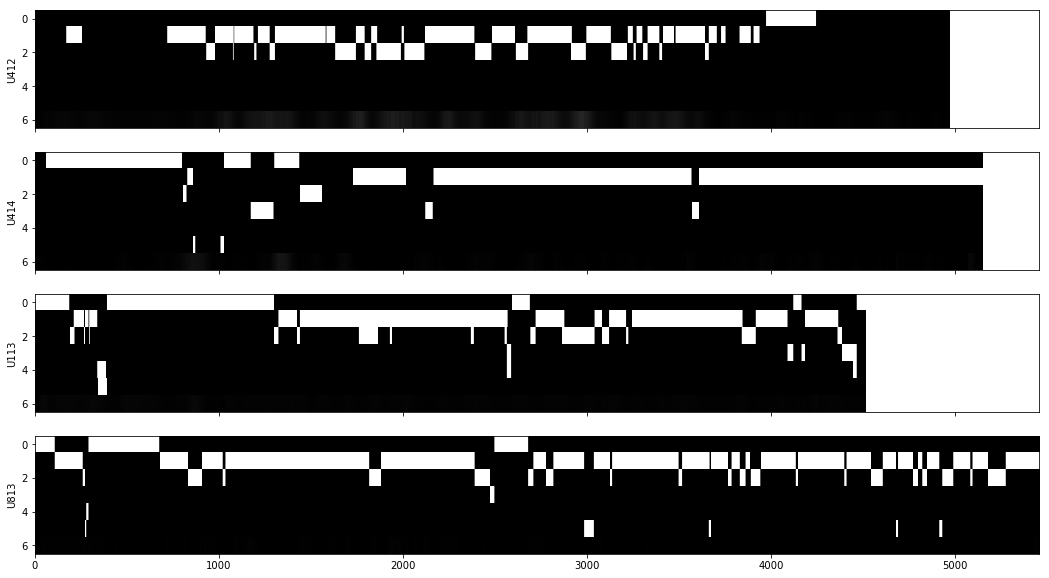

In [284]:
pl.rcParams['figure.figsize'] = [18, 10]

fig, axs = pl.subplots(len(users), 1, sharex=True)
    
user = users[0]
for i, u in enumerate(users):
    print(u, mts[u].shape)
    axs[i].set_ylabel("U%s"% u)
    axs[i].imshow(mts[u], cmap='gray', interpolation='nearest', aspect='auto')
pl.show()